Будем работать с датасетом Online Shoppers Purchasing Intention Dataset.

Прежде чем приступать к построению модели, проведем предобработку данных.

# Импорт библиотек, загрузка и предобработка данных

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score, recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance


import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/aiedu-courses/stepik_eda_and_dev_tools/main/datasets/online_shoppers_intention.csv')

## Описание данных

* `Administrative` - административный тип страницы, которую посетил клиент
* `Administrative_Duration` - время, проведенное на админ. типе страниц
* `Informational` - информационный тип страницы, которую посетил клиент
* `Informational_Duration` - время, проведенное на инфор. типе страниц
* `ProductRelated` - страница с товарами
* `ProductRelated_Duration` - время, проведенное на странице с товарами
* `BounceRates` - процент посетителей, которые зашли на сайт с конкретной страницы и сразу ушли с тойже странице
* `ExitRates` - процент посетителей, которые ушли с сайта с данной страницы после посещения сайта, от всех просмотров данной страницы
* `PageValues` - среднее значение страницы, посещенной пользователем. Значения обычно назначаются важным страницам, таким как страницы оформления заказа или страницы, предшествующие процессу оформления заказа.
* `SpecialDay` - близость какого-либо праздника по времени
* `Month` - месяц
* `OperatingSystems` - операционная система
* `Browser` - браузер
* `Region` - регион
* `TrafficType` - вид трафика
* `VisitorType` - вид посетителя
* `Weekend`	- выходные
* `Revenue` - выручка (целевая переменная)


In [3]:
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [4]:
df.shape

(12330, 18)

## Пропущенные значения

In [5]:
isna_sum = pd.DataFrame(df.isna().sum())
isna_mean = round(df.isna().mean().to_frame()*100, 2) # в процентах
missing = pd.concat([isna_sum, isna_mean], axis=1)
missing.columns = ['# missing', '% missing']
missing

,# missing,% missing
Administrative,0,0.00
Administrative_Duration,0,0.00
Informational,0,0.00
Informational_Duration,199,1.61
ProductRelated,0,0.00
ProductRelated_Duration,491,3.98
BounceRates,0,0.00
ExitRates,99,0.80
PageValues,0,0.00
SpecialDay,0,0.00


Пропуски присутствуют в трех числовых столбцах: 199 (1,61%) пропусков в Informational_Duration, 491 (3,98%) - в ProductRelated_Duration, 99 (0,8%) - в ExitRates.

Заменим пропущенные значения медианами:

In [6]:
values = {"Informational_Duration": df.Informational_Duration.median(),
          "ProductRelated_Duration": df.ProductRelated_Duration.median(),
          "ExitRates": df.ExitRates.median()
          }
df.fillna(value=values, inplace=True)

## Дубликаты

In [7]:
df.duplicated().sum(), df.duplicated().mean()

(112, 0.009083536090835361)

В датасете присутствуют 112 одинаковых строк, что составляет меньше 1% от всех наблюдений. Удаляем дупликаты.

In [8]:
df.drop_duplicates(inplace=True)
df.shape

(12218, 18)

## Целевая переменная

Целевая переменная представлена в формате boolean. Перекодируем в -1 и 1 для удобства дальнейших вычислений.

In [9]:
df = df.astype({'Revenue': 'float32'})

In [10]:
df.sample(10)

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
5026,0,0.000000,0,0.0,3,12.000000,0.066667,0.133333,0.000000,0.0,May,2,4,3,6,Returning_Visitor,False,0.0
3240,2,566.000000,0,0.0,11,574.333333,0.000000,0.015278,34.260778,0.4,May,1,1,8,2,Returning_Visitor,False,1.0
11320,2,29.000000,0,0.0,61,1617.519048,0.013978,0.030296,0.000000,0.0,Nov,3,2,8,2,Returning_Visitor,True,0.0
9147,13,301.561688,1,14.0,55,3328.903752,0.007937,0.014212,38.602048,0.0,Nov,1,1,1,2,Returning_Visitor,False,0.0
6203,1,0.000000,1,66.4,14,668.316667,0.014286,0.028571,44.893459,0.0,Oct,4,2,1,20,Returning_Visitor,True,1.0
2958,4,38.000000,0,0.0,6,107.000000,0.006061,0.042424,0.000000,1.0,May,2,6,2,2,Returning_Visitor,True,0.0
5485,3,9.500000,0,0.0,25,597.625000,0.007692,0.037179,3.296827,0.0,June,2,2,2,3,Returning_Visitor,False,0.0
11079,0,0.000000,0,0.0,2,0.000000,0.200000,0.200000,0.000000,0.0,Nov,2,2,1,1,Returning_Visitor,False,0.0
791,0,0.000000,0,0.0,13,129.500000,0.061538,0.092308,0.000000,0.0,Mar,1,8,1,1,Returning_Visitor,False,0.0
11875,0,0.000000,0,0.0,63,1320.189881,0.000000,0.000468,0.000000,0.0,Nov,2,6,1,2,Returning_Visitor,False,0.0


Теперь датасет готов к построению моделей.

# **1. Построение моделей на числовых признаках**

Таким образом, датасет несбалансированный в отношении целевой переменной, что ожидаемо. Покупки совершаются в 15.6% случаев.

Для решения задачи бинарной классификации можно применить логистическую регрессию. В случае разбалансировки классов модель может прогнозировать класс наибольшего объема (в нашем случае с Revenue равным 0), и тогда метрика accuracy будет равна 0.84, что может ввести в заблуждение. Поэтому в качестве метрик нужно использовать f1_score, ROC-AUC.

In [11]:
df.columns

Index(['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
       'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'Month',
       'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType',
       'Weekend', 'Revenue'],
      dtype='object')

In [12]:
X = df[['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
       'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay']]
y = df['Revenue']

In [13]:
y.value_counts(normalize=True)

,proportion
Revenue,
0.0,0.843837
1.0,0.156163


Разделим данные сразу на train и тест и отмасштабируем данные.

In [14]:
# разделяем на train и test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, shuffle=True, stratify=y)


In [15]:
# масштабируем значения признаков
scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train))
X_train.columns = X.columns

In [16]:
X_test = pd.DataFrame(scaler.transform(X_test))
X_test.columns = X.columns

In [17]:
y.shape

(12218,)

### 1.1 Наивный байесовский классификатор

In [18]:
from sklearn.naive_bayes import GaussianNB

# применяем классификатор, тренируем модель и проверяем на тестовой выборке
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred_gnb = gnb.predict(X_test)

In [19]:
def various_metrics(y_pred):
    print(classification_report(y_test, y_pred))
    print(f'Метрика ROC-AUC составляет: {round(roc_auc_score(y_test, y_pred), 4)}\n')
    print('Матрица ошибок:')
    print(confusion_matrix(y_test, y_pred))

In [20]:
def permutation_importance_num(model):
    feature_names = ['Administrative', 'Administrative_Duration', 'Informational',
                    'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
                    'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay']

    r = permutation_importance(model, X_train, y_train,
                                n_repeats=30,
                                random_state=0)

    for i in r.importances_mean.argsort()[::-1]:
        if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
            print(f"{feature_names[i]   :<8}    "
                  f"{r.importances_mean[i]:.3f}"
                  f" +/- {r.importances_std[i]:.3f}")

In [21]:
various_metrics(y_pred_gnb)

              precision    recall  f1-score   support

         0.0       0.93      0.84      0.88      2578
         1.0       0.44      0.68      0.53       477

    accuracy                           0.81      3055
   macro avg       0.69      0.76      0.71      3055
weighted avg       0.86      0.81      0.83      3055

Метрика ROC-AUC составляет: 0.7579

Матрица ошибок:
[[2162  416]
 [ 154  323]]


In [22]:
permutation_importance_num(gnb)

PageValues    0.083 +/- 0.003
ProductRelated    0.007 +/- 0.002
Informational_Duration    0.005 +/- 0.001
ProductRelated_Duration    0.004 +/- 0.001
Informational    0.004 +/- 0.002


Выводы:

- поскольку accuracy (0.81) ниже размера класса категории -1 (84.4%), **модель Наивный байесовский классификатор имеет низкое качество**
- метрики precision (0.44) и recall (0.68) имеют низкие значения.  
- метрика precision здесь имеет следующую интерпретацию: 44% - это доля объектов класса Revenue=1, которые модель отнесла к классу Revenue=1 и которые действительно относятся к данному классу. Другими словами, модель отнесла к классу Revenue=1 416+323(739) объектов, но фактически на тестовой выборке оказалось, что лишь в 323 случаях (т.е. 44%) она верно классифицировала объекты. Остальные 56%, которые модель классифицировала как Revenue=1, в дейсвительности относятся к классу Revenue=-1. Это говорит о том, что модель не справляется с классификацией объектов, принадлежащих к Revenue=1.
- метрика recall интерпретируется следующим образом: модель нашла 68% объектов из класса Revenue=1 из всех объектов данного класса. Таким образом, из 154+323 (477) объектов, которые фактически относятся к классу Revenue=1, модель смогла найти 323.   
- наиболее значимыми признаками являются `PageValues`, `ProductRelated`, `Informational_Duration`, `ProductRelated_Duration` и `Informational`.

### 1.2 KNN

In [23]:
from sklearn.neighbors import KNeighborsClassifier

knn_cl = KNeighborsClassifier()

knn_cl.fit(X_train, y_train)
y_pred_knn = knn_cl.predict(X_test)

In [24]:
print(f'Значения метрик качества на train:\n')
print(f'accuracy: {accuracy_score(y_train, knn_cl.predict(X_train)):.4f}')
print(f'precision: {precision_score(y_train, knn_cl.predict(X_train)):.4f}')
print(f'recall: {recall_score(y_train, knn_cl.predict(X_train)):.4f}')
print(f'f1-score: {f1_score(y_train, knn_cl.predict(X_train)):.4f}')
print(f'roc-auc: {roc_auc_score(y_train, knn_cl.predict(X_train)):.4f}')

Значения метрик качества на train:

accuracy: 0.9084
precision: 0.8077
recall: 0.5430
f1-score: 0.6494
roc-auc: 0.7595


Проверяем метрики качества на тестовых данных.

In [25]:
various_metrics(y_pred_knn)

              precision    recall  f1-score   support

         0.0       0.91      0.96      0.93      2578
         1.0       0.68      0.47      0.56       477

    accuracy                           0.88      3055
   macro avg       0.80      0.72      0.75      3055
weighted avg       0.87      0.88      0.87      3055

Метрика ROC-AUC составляет: 0.7167

Матрица ошибок:
[[2474  104]
 [ 251  226]]


Выводы:

- Модель knn имеет более высокий показатель accuracy (0.88), чем наивный байесовский метод (0.81) на тестовых данных. При этом у knn показатель precision выше, чем recall, в отличие от GNB.
- Что касается переобучения, то у knn метрики качества на train немного выше, чем на тестовых данных, это говорит о том, что модель переобучилась. Например, f1_score на train составляет 0.6494, в то время как на тесте fi_score составляет 0.56. Таким образом, модель немного адаптируется под данные, что указывает на ее недостатки.

### 1.3 Линейная классификация
(без регуляризации)

In [26]:
from sklearn.linear_model import LinearRegression

clf_lr = LinearRegression()

clf_lr.fit(X_train, y_train)
y_pred_lin = clf_lr.predict(X_test)

In [27]:
print(f"Accuracy: {accuracy_score(y_test, y_pred_lin > 0.5):.2f}")
print(f"Precision: {precision_score(y_test, y_pred_lin > 0.5):.2f}")
print(f"Recall: {recall_score(y_test, y_pred_lin > 0.5):.2f}")
print(f"F1: {f1_score(y_test, y_pred_lin > 0.5):.2f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_lin > 0.5):.2f}")
print('\nМатрица ошибок:')
confusion_matrix(y_test, y_pred_lin > 0.5)

Accuracy: 0.87
Precision: 0.77
Recall: 0.23
F1: 0.36
ROC-AUC: 0.61

Матрица ошибок:


array([[2545,   33],
       [ 366,  111]])

Посмотрим на коэффициенты модели: в первом столбце - имя признака, во втором столбце - вес. Отсортируем датафрейм по увеличению веса. Поскольку данные отнормированы, можно сравнивать признаки по важности на основе размера коэффициентов.

In [28]:
coefs = pd.DataFrame(clf_lr.coef_, index=X.columns)
coefs.sort_values(0)

,0
ExitRates,-0.225262
SpecialDay,-0.068493
Administrative_Duration,-0.052079
Informational_Duration,-0.019446
Informational,0.033223
BounceRates,0.096776
Administrative,0.101906
ProductRelated,0.311756
ProductRelated_Duration,0.510857
PageValues,3.108318


Выводы:

1. Линейная регрессия предсказывает целевую переменную немного лучше, чем предсказание исключительно категории Revenue=0, т.е. accuracy по значению выше, чем 84,4%.
2. Метрика f1_score ниже, чем у knn и байесовского метода (всего 0.36), преимущественно за счет низкого показателя recall, который составляет 0.23, т.е. из 366+111(477) объектов, относящихся к классу Revenue=1, модель сомгла верно идентфицировать лишь 111 (0.23).
3. С точки зрения коэффициентов наиболее значимыми признаками являются `PageValues`, `ProductRelated_Duration`, `ProductRelated` и `ExitRates`.   

### 1.4 Логистическая регрессия

In [29]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()

lr.fit(X_train, y_train)
y_pred_log = lr.predict(X_test)

In [30]:
print(f'Значения метрик качества на train:\n')
print(f'Accuracy: {accuracy_score(y_train, lr.predict(X_train)):.4f}')
print(f'Precision: {precision_score(y_train, lr.predict(X_train)):.4f}')
print(f'Recall: {recall_score(y_train, lr.predict(X_train)):.4f}')
print(f'f1-score: {f1_score(y_train, lr.predict(X_train)):.4f}')
print(f'roc-auc: {roc_auc_score(y_train, lr.predict(X_train)):.4f}')

Значения метрик качества на train:

Accuracy: 0.8729
Precision: 0.7771
Recall: 0.2607
f1-score: 0.3904
roc-auc: 0.6234


In [31]:
various_metrics(y_pred_log)

              precision    recall  f1-score   support

         0.0       0.88      0.98      0.93      2578
         1.0       0.76      0.28      0.41       477

    accuracy                           0.87      3055
   macro avg       0.82      0.63      0.67      3055
weighted avg       0.86      0.87      0.85      3055

Метрика ROC-AUC составляет: 0.6302

Матрица ошибок:
[[2536   42]
 [ 345  132]]


In [32]:
permutation_importance_num(lr)

PageValues    0.052 +/- 0.002
ExitRates    0.006 +/- 0.001
BounceRates    0.001 +/- 0.001


Выводы:

1. У логистической регрессии показатели схожи с линейным классификатором: а именно - низкое значение recall, низкий показатель f1_score, и accuracy немного больше дефолтного значения модели.
2. Примечательно, что логистическая регрессия не переобучилась на данных train, т.е. значения метрик на train и test практически не отличаются.
3. Для логистической модели значение имеют всего три признака: `PageValues`, `ExitRates`, `BounceRates`.     

### 1.5 Метод опорных векторов

In [33]:
from sklearn.svm import SVC

svm = SVC()

svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)

In [34]:
print(f'Значения метрик качества на train:\n')
print(f'accuracy: {accuracy_score(y_train, svm.predict(X_train)):.4f}')
print(f'precision: {precision_score(y_train, svm.predict(X_train)):.4f}')
print(f'recall: {recall_score(y_train, svm.predict(X_train)):.4f}')
print(f'f1-score: {f1_score(y_train, svm.predict(X_train)):.4f}')
print(f'roc-auc: {roc_auc_score(y_train, svm.predict(X_train)):.4f}')

Значения метрик качества на train:

accuracy: 0.8888
precision: 0.7668
recall: 0.4137
f1-score: 0.5374
roc-auc: 0.6952


In [35]:
various_metrics(y_pred_svm)

              precision    recall  f1-score   support

         0.0       0.91      0.98      0.94      2578
         1.0       0.77      0.45      0.57       477

    accuracy                           0.89      3055
   macro avg       0.84      0.71      0.75      3055
weighted avg       0.88      0.89      0.88      3055

Метрика ROC-AUC составляет: 0.7111

Матрица ошибок:
[[2515   63]
 [ 264  213]]


Выводы:

1. Метод опорных векторов демонстраирует более высокие метрики качества f1 и roc_auc, чем линейная регрессия и логистическая регрессия, и не хуже, чем байесовская модель и knn.
2. Модель SVM не переобучилась.  

### 1.6 Решающие деревья

In [36]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=23)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

In [37]:
pd.DataFrame(
    {"feature": X.columns, "importance": dt.feature_importances_}
).sort_values(by="importance", ascending=False).reset_index(drop=True)

,feature,importance
0,PageValues,0.434543
1,ProductRelated_Duration,0.116715
2,ExitRates,0.099542
3,BounceRates,0.089744
4,Administrative_Duration,0.079135
5,ProductRelated,0.073436
6,Administrative,0.047001
7,Informational_Duration,0.034612
8,Informational,0.017923
9,SpecialDay,0.007348


In [38]:
print(f'Значения метрик качества на train:\n')
print(f'accuracy: {accuracy_score(y_train, dt.predict(X_train)):.4f}')
print(f'precision: {precision_score(y_train, dt.predict(X_train)):.4f}')
print(f'recall: {recall_score(y_train, dt.predict(X_train)):.4f}')
print(f'f1-score: {f1_score(y_train, dt.predict(X_train)):.4f}')
print(f'roc-auc: {roc_auc_score(y_train, dt.predict(X_train)):.4f}')

Значения метрик качества на train:

accuracy: 0.9997
precision: 1.0000
recall: 0.9979
f1-score: 0.9990
roc-auc: 0.9990


In [39]:
various_metrics(y_pred_dt)

              precision    recall  f1-score   support

         0.0       0.92      0.90      0.91      2578
         1.0       0.53      0.59      0.56       477

    accuracy                           0.85      3055
   macro avg       0.72      0.74      0.73      3055
weighted avg       0.86      0.85      0.86      3055

Метрика ROC-AUC составляет: 0.7446

Матрица ошибок:
[[2326  252]
 [ 197  280]]


Выводы:

1. В отношении метрик f1 и roc_auc решающие деревья соответсвуют показателям байесовской модели и knn.
2. f1 сбалансирован между precision и recall.
3. Ключевая особенность дерева - оно сильно переобучилось. На train все метрики качества близки к единице, но на тесте показатели далеки от единицы.

### 1.7 Случайный лес

In [40]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=23)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

In [41]:
print(f'Значения метрик качества на train:\n')
print(f'accuracy: {accuracy_score(y_train, rf.predict(X_train)):.4f}')
print(f'precision: {precision_score(y_train, rf.predict(X_train)):.4f}')
print(f'recall: {recall_score(y_train, rf.predict(X_train)):.4f}')
print(f'f1-score: {f1_score(y_train, rf.predict(X_train)):.4f}')
print(f'roc-auc: {roc_auc_score(y_train, rf.predict(X_train)):.4f}')

Значения метрик качества на train:

accuracy: 0.9995
precision: 1.0000
recall: 0.9965
f1-score: 0.9982
roc-auc: 0.9983


In [42]:
pd.DataFrame(
    {"feature": X.columns, "importance": rf.feature_importances_}
).sort_values(by="importance", ascending=False).reset_index(drop=True)

,feature,importance
0,PageValues,0.401447
1,ExitRates,0.124577
2,ProductRelated_Duration,0.122540
3,ProductRelated,0.092771
4,Administrative_Duration,0.078417
5,BounceRates,0.070665
6,Administrative,0.048709
7,Informational_Duration,0.034834
8,Informational,0.019484
9,SpecialDay,0.006555


In [43]:
various_metrics(y_pred_rf)

              precision    recall  f1-score   support

         0.0       0.93      0.95      0.94      2578
         1.0       0.69      0.59      0.63       477

    accuracy                           0.89      3055
   macro avg       0.81      0.77      0.79      3055
weighted avg       0.89      0.89      0.89      3055

Метрика ROC-AUC составляет: 0.7687

Матрица ошибок:
[[2450  128]
 [ 197  280]]


Выводы:

1. Случайный лес, как дерево, переобучился на train, однако на test показывает хорошие результаты по сравнению с другими моделями.
2. Значения метрик f1 и roc_auc выше, чем у предыдущих моделей.

### 1.8 Бустинг

In [44]:
!pip install --upgrade catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 9.6 MB/s eta 0:00:00


In [45]:
from catboost import CatBoostClassifier

cat_boost = CatBoostClassifier()
cat_boost.fit(X_train, y_train)
y_pred_cat_boost = cat_boost.predict(X_test)

Learning rate set to 0.026529
0:	learn: 0.6601535	total: 69.7ms	remaining: 1m 9s
1:	learn: 0.6324685	total: 84.3ms	remaining: 42.1s
2:	learn: 0.6041039	total: 96.6ms	remaining: 32.1s
3:	learn: 0.5790503	total: 107ms	remaining: 26.6s
4:	learn: 0.5559791	total: 121ms	remaining: 24.1s
5:	learn: 0.5355424	total: 136ms	remaining: 22.6s
6:	learn: 0.5156241	total: 148ms	remaining: 20.9s
7:	learn: 0.4966598	total: 161ms	remaining: 19.9s
8:	learn: 0.4794815	total: 175ms	remaining: 19.3s
9:	learn: 0.4629259	total: 196ms	remaining: 19.4s
10:	learn: 0.4506629	total: 209ms	remaining: 18.8s
11:	learn: 0.4370346	total: 222ms	remaining: 18.3s
12:	learn: 0.4245278	total: 238ms	remaining: 18.1s
13:	learn: 0.4125398	total: 252ms	remaining: 17.7s
14:	learn: 0.4022787	total: 267ms	remaining: 17.6s
15:	learn: 0.3922683	total: 281ms	remaining: 17.3s
16:	learn: 0.3832948	total: 291ms	remaining: 16.8s
17:	learn: 0.3753494	total: 305ms	remaining: 16.6s
18:	learn: 0.3672691	total: 334ms	remaining: 17.3s
19:	lear

In [46]:
various_metrics(y_pred_cat_boost)

              precision    recall  f1-score   support

         0.0       0.93      0.95      0.94      2578
         1.0       0.70      0.58      0.64       477

    accuracy                           0.90      3055
   macro avg       0.81      0.77      0.79      3055
weighted avg       0.89      0.90      0.89      3055

Метрика ROC-AUC составляет: 0.7692

Матрица ошибок:
[[2458  120]
 [ 198  279]]


In [47]:
permutation_importance_num(cat_boost)

PageValues    0.183 +/- 0.003
ExitRates    0.033 +/- 0.001
ProductRelated_Duration    0.024 +/- 0.001
ProductRelated    0.021 +/- 0.001
Administrative_Duration    0.021 +/- 0.001
BounceRates    0.017 +/- 0.001
Administrative    0.016 +/- 0.001
Informational_Duration    0.010 +/- 0.001
Informational    0.003 +/- 0.000
SpecialDay    0.003 +/- 0.000


Выводы:

- Catboost по показателям f1_score и roc_auc сопоставима с random_forest.

### Сравнительная таблица с метриками:

In [48]:
data = [
        [accuracy_score(y_test, y_pred_gnb), f1_score(y_test, y_pred_gnb), roc_auc_score(y_test, y_pred_gnb)],
        [accuracy_score(y_test, y_pred_knn), f1_score(y_test, y_pred_knn), roc_auc_score(y_test, y_pred_knn)],
        [accuracy_score(y_test, y_pred_lin > 0.5), f1_score(y_test, y_pred_lin > 0.5), roc_auc_score(y_test, y_pred_lin > 0.5)],
        [accuracy_score(y_test, y_pred_log), f1_score(y_test, y_pred_log), roc_auc_score(y_test, y_pred_log)],
        [accuracy_score(y_test, y_pred_svm), f1_score(y_test, y_pred_svm), roc_auc_score(y_test, y_pred_svm)],
        [accuracy_score(y_test, y_pred_dt), f1_score(y_test, y_pred_dt), roc_auc_score(y_test, y_pred_dt)],
        [accuracy_score(y_test, y_pred_rf), f1_score(y_test, y_pred_rf), roc_auc_score(y_test, y_pred_rf)],
        [accuracy_score(y_test, y_pred_cat_boost), f1_score(y_test, y_pred_cat_boost), roc_auc_score(y_test, y_pred_cat_boost)]
        ]

comp_table = pd.DataFrame(data, columns=['accuracy', 'f1_score', 'roc_auc_score'])
comp_table.index = ['GNB', 'KNN', 'Lin', 'logreg', 'SVM', 'DecTr', 'RandFor', 'Boost' ]

print(comp_table.sort_values(by='f1_score', ascending=False))

         accuracy  f1_score  roc_auc_score
Boost    0.895908  0.636986       0.769179
RandFor  0.893617  0.632768       0.768676
SVM      0.892962  0.565737       0.711052
KNN      0.883797  0.560099       0.716727
DecTr    0.853028  0.555005       0.744626
GNB      0.813421  0.531250       0.757892
logreg   0.873322  0.405530       0.630219
Lin      0.869394  0.357488       0.609952


# **2. Подбор гиперпараметров (на числовых признаках)**

### 2.1. Наивный байесовский классификатор


У данного метода нет гиперпараметров.

### 2.2 KNN

In [ ]:
knn = KNeighborsClassifier()

params = {'n_neighbors' : np.arange(2, 15),
          'weights' : ['uniform', 'distance'],
          'p' : [1, 2],
          'metric': ('minkowski', 'chebyshev')}

gs_knn = GridSearchCV(knn, params, scoring='f1', cv=4, n_jobs=-1, verbose=2)
gs_knn.fit(X_train, y_train)

Fitting 4 folds for each of 104 candidates, totalling 416 fits


GridSearchCV(cv=4, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ('minkowski', 'chebyshev'),
                         'n_neighbors': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
                         'p': [1, 2], 'weights': ['uniform', 'distance']},
             scoring='f1', verbose=2)

In [ ]:
print(f'На train при наилучших параметрах метрика f1_score составляет:\n{gs_knn.best_score_:.4f}')

print(f'Параметры, которые позволяют добиться наивысшего значения метрики f1_score:\n{gs_knn.best_params_}')

На train при наилучших параметрах метрика f1_score составляет:
0.5405
Параметры, которые позволяют добиться наивысшего значения метрики f1_score:
{'metric': 'chebyshev', 'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}


In [ ]:
print(f'Значения метрик качества на train:\n')
print(f'accuracy: {accuracy_score(y_train, gs_knn.best_estimator_.predict(X_train)):.4f}')
print(f'precision: {precision_score(y_train, gs_knn.best_estimator_.predict(X_train)):.4f}')
print(f'recall: {recall_score(y_train, gs_knn.best_estimator_.predict(X_train)):.4f}')
print(f'f1-score: {f1_score(y_train, gs_knn.best_estimator_.predict(X_train)):.4f}')
print(f'roc-auc: {roc_auc_score(y_train, gs_knn.best_estimator_.predict(X_train)):.4f}')

Значения метрик качества на train:

accuracy: 0.9237
precision: 0.8315
recall: 0.6415
f1-score: 0.7243
roc-auc: 0.8087


После применения лучшей модели с подобранными гиперпараметрами метрики качества на train улучшились по сравнению с knn моделью с дефолтными параметрами. Например, f1 удалось увеличить с 0.6494 до 0.7243, accuracy выросла с 0.9084 до 0.9237, при этом roc-auc немного снизился.

Однако теперь проверим качество модели knn с подобраными гиперпараметрами на тестовой выборке.  

In [ ]:
y_pred_knn_hyper = gs_knn.best_estimator_.predict(X_test)

various_metrics(y_pred_knn_hyper)

              precision    recall  f1-score   support

           0       0.91      0.94      0.93      2578
           1       0.62      0.50      0.55       477

    accuracy                           0.87      3055
   macro avg       0.76      0.72      0.74      3055
weighted avg       0.86      0.87      0.87      3055

Метрика ROC-AUC составляет: 0.7201

Матрица ошибок:
[[2432  146]
 [ 240  237]]


Выводы:

- На тестовой выборке модель с гиперпараметрами показывает аналогичные результаты (в отношении f1_score, accuracy, roc_auc), что и модель с дефолтными параметрами. Это свидетельствует о том, что произошло переобучение модели.


### 2.3 Линейная классификация

Гиперпараметром для модели линейной классификации служит порог (threshold).

Построим на одном графике метрики precision, recall и f1 score в зависимости от порога.

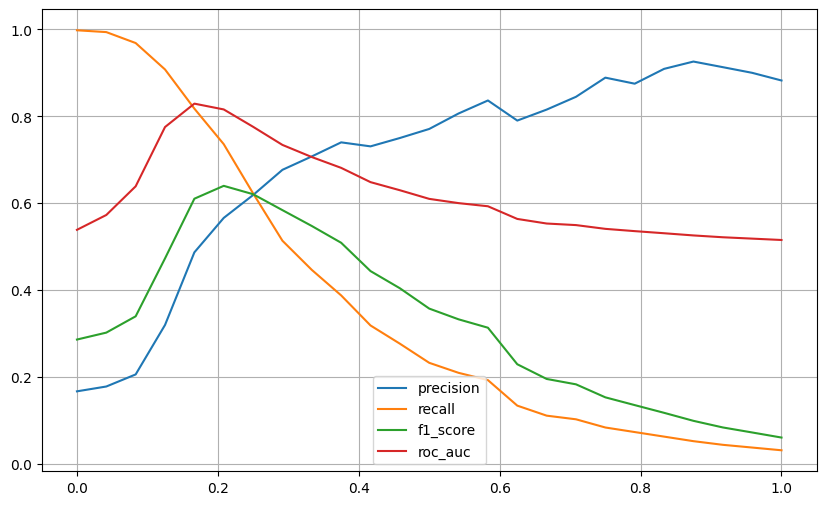

In [ ]:
thresholds = np.linspace(0, 1, 25)
precisions = [precision_score(y_test, y_pred_lin > thrsh) for thrsh in thresholds]
recalls = [recall_score(y_test, y_pred_lin > thrsh) for thrsh in thresholds]
f1_scores = [f1_score(y_test, y_pred_lin > thrsh) for thrsh in thresholds]
roc_aucs = [roc_auc_score(y_test, y_pred_lin > thrsh) for thrsh in thresholds]

plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label="precision")
plt.plot(thresholds, recalls, label="recall")
plt.plot(thresholds, f1_scores, label="f1_score")
plt.plot(thresholds, roc_aucs, label="roc_auc")
plt.grid()
plt.legend()
plt.show()

Посчитаем пороги, которые соответствуют максимальным значениям f1_score и roc_auc.

In [ ]:
thrsh_best = thresholds[np.argmax(f1_scores)]
print(
    f"Лучший порог для f1_score: {thrsh_best:.3f}.\nДля данного порога f1_score составляет {np.max(f1_scores):.3f}."
)

thrsh_best_roc = thresholds[np.argmax(roc_aucs)]
print(
    f"\nЛучший порог для roc_auc: {thrsh_best_roc:.3f}.\nДля данного порога roc_auc составляет {np.max(roc_aucs):.3f}."
)

Лучший порог для f1_score: 0.208.
Для данного порога f1_score составляет 0.640.

Лучший порог для roc_auc: 0.167.
Для данного порога roc_auc составляет 0.829.


Метрики на тесте при пороге 0.208:

In [ ]:
print(f"Accuracy: {accuracy_score(y_test, y_pred_lin > thrsh_best):.2f}")
print(f"Precision: {precision_score(y_test, y_pred_lin > thrsh_best):.2f}")
print(f"Recall: {recall_score(y_test, y_pred_lin > thrsh_best):.2f}")
print(f"F1: {f1_score(y_test, y_pred_lin > thrsh_best):.2f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_lin > thrsh_best):.2f}")
print('\nМатрица ошибок:')
confusion_matrix(y_test, y_pred_lin > thrsh_best)

Accuracy: 0.87
Precision: 0.57
Recall: 0.74
F1: 0.64
ROC-AUC: 0.82

Матрица ошибок:


array([[2309,  269],
       [ 126,  351]])

Метрики на тесте при пороге 0.167:

In [ ]:
print(f"Accuracy: {accuracy_score(y_test, y_pred_lin > thrsh_best_roc):.2f}")
print(f"Precision: {precision_score(y_test, y_pred_lin > thrsh_best_roc):.2f}")
print(f"Recall: {recall_score(y_test, y_pred_lin > thrsh_best_roc):.2f}")
print(f"F1: {f1_score(y_test, y_pred_lin > thrsh_best_roc):.2f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_lin > thrsh_best_roc):.2f}")
print('\nМатрица ошибок:')
confusion_matrix(y_test, y_pred_lin > thrsh_best_roc)

Accuracy: 0.84
Precision: 0.49
Recall: 0.82
F1: 0.61
ROC-AUC: 0.83

Матрица ошибок:


array([[2167,  411],
       [  87,  390]])

Выводы:
1. Мы подобрали два потенциальных порога: первый порог составляет 0.208, второй - 0.167. Первый порог подобран исходя из максимизации метрики f1_score, второй порог в размере 0.167 отражает максимальный уровень метрики roc_auc.  
2. При пороге 0.208 на тестовых данных показатели f1_score и roc_auc поднялись с 0.36 до 0.64 и с 0.61 до 0.82 соответственно.
3. При пороге 0.167 на тестовых данных показатели f1_score и roc_auc поднялись с 0.36 до 0.61 и с 0.61 до 0.83 соответственно.
4. Заметим, что значения показателей f1_score и roc_auc при пороге 0.208 на train (f1_score=0.64, roc_auc=0.829) и test (f1_score=0.64, roc_auc=0.82) практически совпадают, что говорит о том, что модель не переобучилась.
5. Таким образом, подбор гиперпараметра "порог" позволил существенно улучшить модель.


### 2.4 Логистическая регрессия

In [ ]:
lr = LogisticRegression()

# params = {"C": [3, 5, 10, 20, 30, 40, 50],
#           "penalty": ["l1", "l2"]}


params = [
    {'penalty':['l1','l2','elasticnet','none'],
    'C' : [13, 14, 15, 16, 17, 18, 19, 20, 21],
    'solver': ['lbfgs','newton-cg','liblinear','sag','saga'],
    'max_iter'  : [100, 150, 200, 250]
}
]

gs_lr = GridSearchCV(lr, params, scoring='f1', cv=4, n_jobs=-1)
gs_lr.fit(X_train, y_train)

GridSearchCV(cv=4, estimator=LogisticRegression(), n_jobs=-1,
             param_grid=[{'C': [13, 14, 15, 16, 17, 18, 19, 20, 21],
                          'max_iter': [100, 150, 200, 250],
                          'penalty': ['l1', 'l2', 'elasticnet', 'none'],
                          'solver': ['lbfgs', 'newton-cg', 'liblinear', 'sag',
                                     'saga']}],
             scoring='f1')

In [ ]:
print(f'При обучении модели при наилучших параметрах метрика f1_score составляет:\n{gs_lr.best_score_:.4f}')

print(f'Параметры, которые позволяют добиться наивысшего значения метрики f1_score:\n{gs_lr.best_params_}')

При обучении модели при наилучших параметрах метрика f1_score составляет:
0.4905
Параметры, которые позволяют добиться наивысшего значения метрики f1_score:
{'C': 17, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}


In [ ]:
print(f'Значения метрик качества на train:\n')
print(f'Accuracy: {accuracy_score(y_train, gs_lr.best_estimator_.predict(X_train)):.4f}')
print(f'Precision: {precision_score(y_train, gs_lr.best_estimator_.predict(X_train)):.4f}')
print(f'Recall: {recall_score(y_train, gs_lr.best_estimator_.predict(X_train)):.4f}')
print(f'f1-score: {f1_score(y_train, gs_lr.best_estimator_.predict(X_train)):.4f}')
print(f'roc-auc: {roc_auc_score(y_train, gs_lr.best_estimator_.predict(X_train)):.4f}')

Значения метрик качества на train:

Accuracy: 0.8822
Precision: 0.7558
Recall: 0.3634
f1-score: 0.4908
roc-auc: 0.6708


In [ ]:
y_pred_lr_hyper = gs_lr.best_estimator_.predict(X_test)

various_metrics(y_pred_lr_hyper)

              precision    recall  f1-score   support

           0       0.89      0.97      0.93      2578
           1       0.74      0.38      0.50       477

    accuracy                           0.88      3055
   macro avg       0.82      0.68      0.72      3055
weighted avg       0.87      0.88      0.87      3055

Метрика ROC-AUC составляет: 0.6782

Матрица ошибок:
[[2513   65]
 [ 295  182]]


In [ ]:
permutation_importance_num(gs_lr.best_estimator_)

PageValues    0.077 +/- 0.002
ExitRates    0.005 +/- 0.001
BounceRates    0.001 +/- 0.000
Administrative_Duration    0.000 +/- 0.000


Выводы:
1. Модель достигла наилучшего качества в отношении метрики f_score (0.4905) при следующих гиперпараметрах:
*   'C': 17,
*   'max_iter': 150,
*   'penalty': 'l1',
*    'solver': 'liblinear'

2. По сравнению с дефолтной моделью метрики f1_score и roc_auc на тестовых данных выросли с 0.41 до 0.50 и с 0.6302 до 0.6782 соответственно, что говорит об улучшении качества модели с подбором гиперпараметров.
3. Что касается переобучения новой модели, то сравнение f1_score (0.4908 на train vs 0.50 на test) и roc_auc (0.6708 на train vs 0.6782 на test) на train и test позволяет заключить, что модель не переобучилась.
4. Таким образом, подбор гиперпараметров позволил улучшить качество модели. Однако, логистическая модель оказалась линейной.  

### 2.5 Метод опорных векторов

In [ ]:
# самая долгая модель - даже при 18 комбинациях ждать очень долго
# с kernel = 'linear' модель так и не обучилась (слишком долго)

svm = SVC(kernel='rbf')

params = {'C': [900, 1000, 1100],
          'gamma': [1, 0.1]
            }

gs_svm = GridSearchCV(svm, params, scoring='f1', cv=3, n_jobs=-1, verbose=3)

# fitting the model for grid search
gs_svm.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


GridSearchCV(cv=3, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [900, 1000, 1100], 'gamma': [1, 0.1]},
             scoring='f1', verbose=3)

In [ ]:
print(f'При обучении модели при наилучших параметрах метрика f1_score составляет:\n{gs_svm.best_score_:.4f}')

print(f'Параметры, которые позволяют добиться наивысшего значения метрики f1_score:\n{gs_svm.best_params_}')

При обучении модели при наилучших параметрах метрика f1_score составляет:
0.5819
Параметры, которые позволяют добиться наивысшего значения метрики f1_score:
{'C': 1100, 'gamma': 1}


In [ ]:
print(f'Значения метрик качества на train:\n')
print(f'Accuracy: {accuracy_score(y_train, gs_svm.best_estimator_.predict(X_train)):.4f}')
print(f'Precision: {precision_score(y_train, gs_svm.best_estimator_.predict(X_train)):.4f}')
print(f'Recall: {recall_score(y_train, gs_svm.best_estimator_.predict(X_train)):.4f}')
print(f'f1-score: {f1_score(y_train, gs_svm.best_estimator_.predict(X_train)):.4f}')
print(f'roc-auc: {roc_auc_score(y_train, gs_svm.best_estimator_.predict(X_train)):.4f}')

Значения метрик качества на train:

Accuracy: 0.8989
Precision: 0.7655
Recall: 0.5087
f1-score: 0.6113
roc-auc: 0.7399


In [ ]:
y_pred_svm_hyper = gs_svm.best_estimator_.predict(X_test)

various_metrics(y_pred_svm_hyper)

              precision    recall  f1-score   support

           0       0.91      0.97      0.94      2578
           1       0.73      0.50      0.60       477

    accuracy                           0.89      3055
   macro avg       0.82      0.73      0.77      3055
weighted avg       0.88      0.89      0.89      3055

Метрика ROC-AUC составляет: 0.7345

Матрица ошибок:
[[2490   88]
 [ 237  240]]


Выводы:
- метрики качества f1_score и roc_auc немного увеличились после подбора гиперпараметров.

### 2.6 Решающие деревья

In [49]:
# модель обучилась за 10 секунд

from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=23)

params = {'max_features': ['auto', 'sqrt', 'log2'],
          'ccp_alpha': [0.1, .01, .001],
          'max_depth' : [2, 3, 4, 5],
          'criterion' :['gini', 'entropy']
          }

gs_dt = GridSearchCV(dt, params, scoring='f1', cv=3, n_jobs=-1, verbose=3)

# fitting the model for grid search
gs_dt.fit(X_train, y_train)

Fitting 3 folds for each of 72 candidates, totalling 216 fits


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=23), n_jobs=-1,
             param_grid={'ccp_alpha': [0.1, 0.01, 0.001],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 4, 5],
                         'max_features': ['auto', 'sqrt', 'log2']},
             scoring='f1', verbose=3)

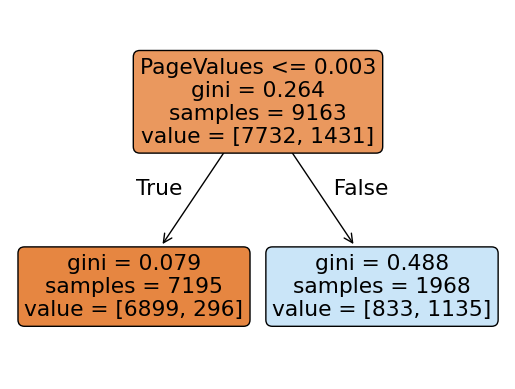

In [50]:
from sklearn.tree import plot_tree

plot_tree(gs_dt.best_estimator_, feature_names=X.columns, filled=True, rounded=True)
plt.show()

In [51]:
pd.DataFrame(
    {"feature": X.columns, "importance": gs_dt.best_estimator_.feature_importances_}
).sort_values(by="importance", ascending=False).reset_index(drop=True)

,feature,importance
0,PageValues,1.0
1,Administrative,0.0
2,Administrative_Duration,0.0
3,Informational,0.0
4,Informational_Duration,0.0
5,ProductRelated,0.0
6,ProductRelated_Duration,0.0
7,BounceRates,0.0
8,ExitRates,0.0
9,SpecialDay,0.0


Таким образом, PageValues является единственным важным признаком в обучении и использовании модели.

In [52]:
print(f'При обучении модели при наилучших параметрах метрика f1_score составляет:\n{gs_dt.best_score_:.4f}')

print(f'Параметры, которые позволяют добиться наивысшего значения метрики f1_score:\n{gs_dt.best_params_}')

При обучении модели при наилучших параметрах метрика f1_score составляет:
0.6651
Параметры, которые позволяют добиться наивысшего значения метрики f1_score:
{'ccp_alpha': 0.01, 'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt'}


In [53]:
print(f'Значения метрик качества на train:\n')
print(f'Accuracy: {accuracy_score(y_train, gs_dt.best_estimator_.predict(X_train)):.4f}')
print(f'Precision: {precision_score(y_train, gs_dt.best_estimator_.predict(X_train)):.4f}')
print(f'Recall: {recall_score(y_train, gs_dt.best_estimator_.predict(X_train)):.4f}')
print(f'f1-score: {f1_score(y_train, gs_dt.best_estimator_.predict(X_train)):.4f}')
print(f'roc-auc: {roc_auc_score(y_train, gs_dt.best_estimator_.predict(X_train)):.4f}')

Значения метрик качества на train:

Accuracy: 0.8768
Precision: 0.5767
Recall: 0.7932
f1-score: 0.6678
roc-auc: 0.8427


В отличие от модели без подбора гиперпараметров данная модель с гиперпараметрами не переобучилась.

In [54]:
y_pred_dt_hyper = gs_dt.best_estimator_.predict(X_test)

various_metrics(y_pred_dt_hyper)

              precision    recall  f1-score   support

         0.0       0.96      0.88      0.92      2578
         1.0       0.56      0.80      0.66       477

    accuracy                           0.87      3055
   macro avg       0.76      0.84      0.79      3055
weighted avg       0.90      0.87      0.88      3055

Метрика ROC-AUC составляет: 0.8413

Матрица ошибок:
[[2273  305]
 [  95  382]]


Выводы:
1. Модель подобрала самые оптимальные гиперпараметры, которые максимизируют f1_score:
    *   'ccp_alpha': 0.01
    *   'criterion': 'gini'
    *   'max_depth': 2
    *   'max_features': 'sqrt'
2. Это позволило значительно улучшить качество модели, исходя из метрик f1_score и roc_auc. Например, на тестовых данных показатель f1_score вырос с 0.56 до 0.66 (преимущественно за счет улучшения recall), а roc_auc увеличился с 0.7446 до 0.8413.
3. Переобучения модели не происходит, так как метрики качества на train и test совпадают.
4. **На данном этапе это самая качественная модель.**

### 2.7 Случайный лес

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=23)

params = {'n_estimators': list(range(50, 80, 5)),
          'max_depth': list(range(10, 30, 3)),
          'max_features': ['sqrt', 'log2']
          }

gs_rf = GridSearchCV(rf, params, scoring='f1', cv=3, n_jobs=-1, verbose=3)

# fitting the model for grid search
gs_rf.fit(X_train, y_train)

Fitting 3 folds for each of 84 candidates, totalling 252 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=23), n_jobs=-1,
             param_grid={'max_depth': [10, 13, 16, 19, 22, 25, 28],
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [50, 55, 60, 65, 70, 75]},
             scoring='f1', verbose=3)

In [ ]:
print(f'При обучении модели при наилучших параметрах метрика f1_score составляет:\n{gs_rf.best_score_:.4f}')

print(f'Параметры, которые позволяют добиться наивысшего значения метрики f1_score:\n{gs_rf.best_params_}')

При обучении модели при наилучших параметрах метрика f1_score составляет:
0.6257
Параметры, которые позволяют добиться наивысшего значения метрики f1_score:
{'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 70}


In [ ]:
permutation_importance_num(gs_rf.best_estimator_)

PageValues    0.174 +/- 0.003
ExitRates    0.038 +/- 0.001
ProductRelated_Duration    0.026 +/- 0.001
BounceRates    0.020 +/- 0.001
ProductRelated    0.020 +/- 0.001
Administrative    0.018 +/- 0.001
Administrative_Duration    0.015 +/- 0.001
Informational_Duration    0.007 +/- 0.000
Informational    0.005 +/- 0.000
SpecialDay    0.002 +/- 0.000


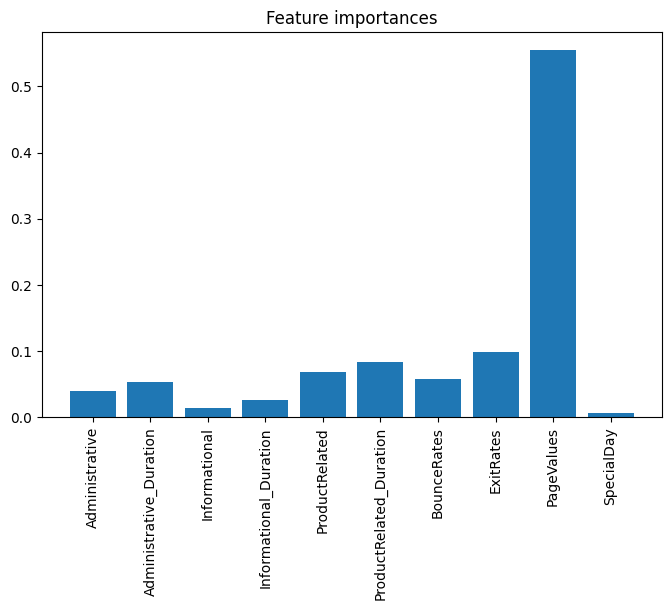

In [ ]:
plt.figure(figsize=(8, 5))
plt.title("Feature importances")
plt.tick_params(axis='x', labelrotation = 90)
plt.bar(X.columns, gs_rf.best_estimator_.feature_importances_);

In [ ]:
print(f'Значения метрик качества на train:\n')
print(f'Accuracy: {accuracy_score(y_train, gs_rf.best_estimator_.predict(X_train)):.4f}')
print(f'Precision: {precision_score(y_train, gs_rf.best_estimator_.predict(X_train)):.4f}')
print(f'Recall: {recall_score(y_train, gs_rf.best_estimator_.predict(X_train)):.4f}')
print(f'f1-score: {f1_score(y_train, gs_rf.best_estimator_.predict(X_train)):.4f}')
print(f'roc-auc: {roc_auc_score(y_train, gs_rf.best_estimator_.predict(X_train)):.4f}')

Значения метрик качества на train:

Accuracy: 0.9498
Precision: 0.9285
Recall: 0.7352
f1-score: 0.8206
roc-auc: 0.8623


In [ ]:
y_pred_rf_hyper = gs_rf.best_estimator_.predict(X_test)

various_metrics(y_pred_rf_hyper)

              precision    recall  f1-score   support

           0       0.92      0.96      0.94      2578
           1       0.72      0.58      0.64       477

    accuracy                           0.90      3055
   macro avg       0.82      0.77      0.79      3055
weighted avg       0.89      0.90      0.89      3055

Метрика ROC-AUC составляет: 0.7675

Матрица ошибок:
[[2471  107]
 [ 202  275]]


### 2.8 Бустинг

Для практики рассмотрим только CatBoost.

In [ ]:
from catboost import CatBoostClassifier

cat_boost = CatBoostClassifier()

params = {'learning_rate': [0.03, 0.1],
        'depth': [4, 6, 10],
        'iterations': list(range(10, 101, 10))
          }

gs_boost = GridSearchCV(cat_boost, params, scoring='f1', cv=3, n_jobs=-1, verbose=3)

# fitting the model for grid search
gs_boost.fit(X_train, y_train)

Fitting 3 folds for each of 60 candidates, totalling 180 fits
0:	learn: 0.6729131	total: 3.02ms	remaining: 27.1ms
1:	learn: 0.6540007	total: 5.59ms	remaining: 22.4ms
2:	learn: 0.6365279	total: 7.48ms	remaining: 17.4ms
3:	learn: 0.6197557	total: 9.31ms	remaining: 14ms
4:	learn: 0.6036942	total: 11.4ms	remaining: 11.4ms
5:	learn: 0.5887533	total: 13.6ms	remaining: 9.05ms
6:	learn: 0.5745933	total: 15.8ms	remaining: 6.79ms
7:	learn: 0.5606715	total: 18.1ms	remaining: 4.52ms
8:	learn: 0.5476683	total: 20.3ms	remaining: 2.25ms
9:	learn: 0.5352174	total: 22.5ms	remaining: 0us


GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostClassifier object at 0x79d1a1fcbeb0>,
             n_jobs=-1,
             param_grid={'depth': [4, 6, 10],
                         'iterations': [10, 20, 30, 40, 50, 60, 70, 80, 90,
                                        100],
                         'learning_rate': [0.03, 0.1]},
             scoring='f1', verbose=3)

In [ ]:
print(f'При обучении модели при наилучших параметрах метрика f1_score составляет:\n{gs_boost.best_score_:.4f}')

print(f'Параметры, которые позволяют добиться наивысшего значения метрики f1_score:\n{gs_boost.best_params_}')

При обучении модели при наилучших параметрах метрика f1_score составляет:
0.6451
Параметры, которые позволяют добиться наивысшего значения метрики f1_score:
{'depth': 4, 'iterations': 10, 'learning_rate': 0.03}


In [ ]:
print(f'Значения метрик качества на train:\n')
print(f'Accuracy: {accuracy_score(y_train, gs_boost.best_estimator_.predict(X_train)):.4f}')
print(f'Precision: {precision_score(y_train, gs_boost.best_estimator_.predict(X_train)):.4f}')
print(f'Recall: {recall_score(y_train, gs_boost.best_estimator_.predict(X_train)):.4f}')
print(f'f1-score: {f1_score(y_train, gs_boost.best_estimator_.predict(X_train)):.4f}')
print(f'roc-auc: {roc_auc_score(y_train, gs_boost.best_estimator_.predict(X_train)):.4f}')

Значения метрик качества на train:

Accuracy: 0.8963
Precision: 0.6709
Recall: 0.6597
f1-score: 0.6653
roc-auc: 0.7999


In [ ]:
y_pred_boost_hyper = gs_boost.best_estimator_.predict(X_test)

various_metrics(y_pred_boost_hyper)

              precision    recall  f1-score   support

           0       0.94      0.93      0.93      2578
           1       0.64      0.66      0.65       477

    accuracy                           0.89      3055
   macro avg       0.79      0.80      0.79      3055
weighted avg       0.89      0.89      0.89      3055

Метрика ROC-AUC составляет: 0.7961

Матрица ошибок:
[[2402  176]
 [ 162  315]]


In [ ]:
permutation_importance_num(gs_boost.best_estimator_)

PageValues    0.174 +/- 0.003
Administrative    0.005 +/- 0.001
BounceRates    0.005 +/- 0.001
Informational_Duration    0.004 +/- 0.001
ProductRelated    0.003 +/- 0.001
ExitRates    0.002 +/- 0.001
Administrative_Duration    0.001 +/- 0.000


Выводы:

1. После подбора параметров удалось немного улучшить модель.
2. Модель CatBoost уступает решающему дереву по метрике roc_auc.


### Сравнительная таблица с метриками:

In [ ]:
data_hyper = [
        [accuracy_score(y_test, y_pred_gnb), f1_score(y_test, y_pred_gnb), roc_auc_score(y_test, y_pred_gnb)],
        [accuracy_score(y_test, y_pred_knn_hyper), f1_score(y_test, y_pred_knn_hyper), roc_auc_score(y_test, y_pred_knn_hyper)],
        [accuracy_score(y_test, y_pred_lin > thrsh_best), f1_score(y_test, y_pred_lin > thrsh_best), roc_auc_score(y_test, y_pred_lin > thrsh_best)],
        [accuracy_score(y_test, y_pred_lr_hyper), f1_score(y_test, y_pred_lr_hyper), roc_auc_score(y_test, y_pred_lr_hyper)],
        [accuracy_score(y_test, y_pred_svm_hyper), f1_score(y_test, y_pred_svm_hyper), roc_auc_score(y_test, y_pred_svm_hyper)],
        [accuracy_score(y_test, y_pred_dt_hyper), f1_score(y_test, y_pred_dt_hyper), roc_auc_score(y_test, y_pred_dt_hyper)],
        [accuracy_score(y_test, y_pred_rf_hyper), f1_score(y_test, y_pred_rf_hyper), roc_auc_score(y_test, y_pred_rf_hyper)],
        [accuracy_score(y_test, y_pred_boost_hyper), f1_score(y_test, y_pred_boost_hyper), roc_auc_score(y_test, y_pred_boost_hyper)]
        ]

df_hyper = pd.DataFrame(data_hyper, columns=['accuracy', 'f1_score', 'roc_auc_score'])
df_hyper.index = ['GNB', 'KNN', 'Lin', 'logreg','SVM', 'DecTr', 'RandFor', 'Boost' ]
print('После нахождения гиперпараметров')
print(df_hyper.sort_values(by='f1_score', ascending=False))

print('\nДефолтные модели')
print(comp_table.sort_values(by='f1_score', ascending=False))

После нахождения гиперпараметров
         accuracy  f1_score  roc_auc_score
DecTr    0.869067  0.656357       0.841265
Boost    0.889362  0.650826       0.796054
RandFor  0.898854  0.640279       0.767507
Lin      0.870704  0.639927       0.815752
SVM      0.893617  0.596273       0.734505
KNN      0.873650  0.551163       0.720111
GNB      0.813421  0.531250       0.757892
logreg   0.882160  0.502762       0.678169

Дефолтные модели
         accuracy  f1_score  roc_auc_score
Boost    0.895908  0.636986       0.769179
RandFor  0.893617  0.632768       0.768676
SVM      0.892962  0.565737       0.711052
KNN      0.883797  0.560099       0.716727
DecTr    0.853028  0.555005       0.744626
GNB      0.813421  0.531250       0.757892
logreg   0.873322  0.405530       0.630219
Lin      0.869394  0.357488       0.609952


# **3. Добавление категориальных признаков в лучшую модель**
(Решающее дерево)

Лучшей моделью с точки зрения значения f1_score оказалось решающее дерево. В отношении скорости реализации модели решающее дерево также не уступает другим моделям. Это обусловлено тем, что в нашем датасете имеется признак PageValues, влияние которого на целевую переменную в несколько раз превышает другие признаки, что позволяет оперативно построить модель с глубиной равной двум (т.е. с одной вершиной).  

### 3.1 One-hot encoding

In [55]:
df = df.astype({'Weekend': 'float32'})

X_full = df.drop('Revenue', axis=1)
y = df['Revenue']

categorical = ['Month', 'OperatingSystems', 'Browser', 'Region',
              'TrafficType', 'VisitorType', 'Weekend']

In [56]:
X_dum = pd.get_dummies(X_full, columns=categorical, drop_first=True)
print(f"Data shape: {X_dum.shape}")

Data shape: (12218, 69)


Проверим верность операций, связанных с one-hot encoding.

In [57]:
numeric = ['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
       'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay']
categorical = ['Month', 'OperatingSystems', 'Browser', 'Region',
              'TrafficType', 'VisitorType', 'Weekend']

number_columns = X_full[categorical].nunique().sum() - len(categorical) + len(numeric)
print(f'После one-hot encoding количество столбцов в датафрейме с признаками должно быть: {number_columns}')

# Проверка, что one-hot encoding произошло верно
assert X_dum.shape[1] == number_columns, 'неверные расчеты'

После one-hot encoding количество столбцов в датафрейме с признаками должно быть: 69


### 3.2 Обучение модели без гиперпараметров

In [58]:
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X_dum, y, test_size=0.25, random_state=42, shuffle=True, stratify=y)

from sklearn.tree import DecisionTreeClassifier

dt_cat = DecisionTreeClassifier(random_state=23)
dt_cat.fit(X_train_full, y_train_full)
y_pred_dt_cat = dt_cat.predict(X_test_full)

In [59]:
pd.DataFrame(
    {"feature": X_dum.columns, "importance": dt_cat.feature_importances_}
).sort_values(by="importance", ascending=False).reset_index(drop=True).head(10)

,feature,importance
0,PageValues,0.432669
1,ProductRelated_Duration,0.083597
2,BounceRates,0.075856
3,ProductRelated,0.070270
4,ExitRates,0.063323
5,Administrative_Duration,0.050429
6,Administrative,0.031904
7,Month_Nov,0.023737
8,Informational_Duration,0.019909
9,Region_3,0.012640


In [60]:
print(f'Значения метрик качества на train:\n')
print(f'accuracy: {accuracy_score(y_train_full, dt_cat.predict(X_train_full)):.4f}')
print(f'precision: {precision_score(y_train_full, dt_cat.predict(X_train_full)):.4f}')
print(f'recall: {recall_score(y_train_full, dt_cat.predict(X_train_full)):.4f}')
print(f'f1-score: {f1_score(y_train_full, dt_cat.predict(X_train_full)):.4f}')
print(f'roc-auc: {roc_auc_score(y_train_full, dt_cat.predict(X_train_full)):.4f}')

Значения метрик качества на train:

accuracy: 1.0000
precision: 1.0000
recall: 1.0000
f1-score: 1.0000
roc-auc: 1.0000


Как и ожидалось, модель без гиперпараметров переобучилась.

Проверим качество модели на тестовой выборке.

In [61]:
print(classification_report(y_test_full, y_pred_dt_cat))
print(f'Метрика ROC-AUC составляет: {round(roc_auc_score(y_test_full, y_pred_dt_cat), 4)}\n')
print('Матрица ошибок:')
print(confusion_matrix(y_test_full, y_pred_dt_cat))

              precision    recall  f1-score   support

         0.0       0.93      0.91      0.92      2578
         1.0       0.56      0.61      0.58       477

    accuracy                           0.86      3055
   macro avg       0.74      0.76      0.75      3055
weighted avg       0.87      0.86      0.87      3055

Метрика ROC-AUC составляет: 0.7619

Матрица ошибок:
[[2345  233]
 [ 184  293]]


In [62]:
data_cat = [
        [accuracy_score(y_test, y_pred_dt), f1_score(y_test, y_pred_dt), roc_auc_score(y_test, y_pred_dt)],
        [accuracy_score(y_test_full, y_pred_dt_cat), f1_score(y_test_full, y_pred_dt_cat), roc_auc_score(y_test_full, y_pred_dt_cat)]
        ]

df_cat = pd.DataFrame(data_cat, columns=['accuracy', 'f1_score', 'roc_auc_score'])
df_cat.index = ['DecTr', 'DecTr_cat' ]
print('После добавления категориальных признаков')
print(df_cat.sort_values(by='f1_score', ascending=False))


После добавления категориальных признаков
           accuracy  f1_score  roc_auc_score
DecTr_cat  0.863502  0.584247       0.761938
DecTr      0.853028  0.555005       0.744626


Выводы:
- Модель с без подбора гиперпараметров с категориальными признаками имеет чуть более высокие значения метрик качества f1_score и roc_auc, чем модель без категориальных признаков.

### 3.3 Подбор гиперпараметров

In [63]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=23)

params_cat = {'max_features': ['auto', 'sqrt', 'log2'],
          'ccp_alpha': [0.1, .01, .001],
          'max_depth' : list(range(2,11)),
          'criterion' :['gini', 'entropy']
          }

gs_dt_cat = GridSearchCV(dt, params_cat, scoring='f1', cv=3, n_jobs=-1, verbose=3)

# fitting the model for grid search
gs_dt_cat.fit(X_train_full, y_train_full)

Fitting 3 folds for each of 162 candidates, totalling 486 fits


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=23), n_jobs=-1,
             param_grid={'ccp_alpha': [0.1, 0.01, 0.001],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'max_features': ['auto', 'sqrt', 'log2']},
             scoring='f1', verbose=3)

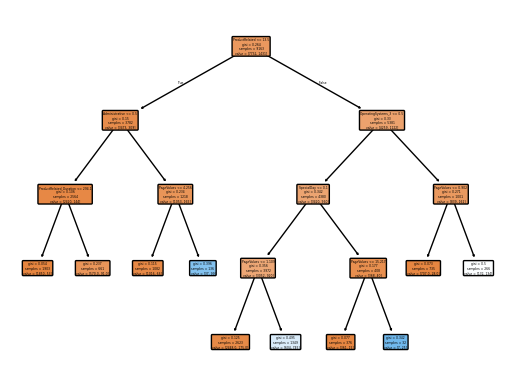

In [64]:
from sklearn.tree import plot_tree

plot_tree(gs_dt_cat.best_estimator_, feature_names=X_dum.columns, filled=True, rounded=True)
plt.show()

In [65]:
pd.DataFrame(
    {"feature": X_dum.columns, "importance": gs_dt_cat.best_estimator_.feature_importances_}
).sort_values(by="importance", ascending=False).reset_index(drop=True).head(10)

,feature,importance
0,PageValues,0.851739
1,ProductRelated,0.094377
2,SpecialDay,0.017447
3,ProductRelated_Duration,0.015635
4,Administrative,0.013724
5,OperatingSystems_3,0.007079
6,Region_9,0.000000
7,TrafficType_6,0.000000
8,TrafficType_5,0.000000
9,TrafficType_4,0.000000


Двумя наиболее важными признаками являются `PageValues` и `ProductRelated`. Стоит отметить, что у модели без категориальных признаков только `PageValues` имеет значение, т.е. добавление категориальных признаков привело к увеличению важности числового признака `ProductRelated`, что сложно объяснить с логической точки зрения (вероятно, это связано с переобучением).

In [66]:
print(f'При обучении модели при наилучших параметрах метрика f1_score составляет:\n{gs_dt_cat.best_score_:.4f}')

print(f'Параметры, которые позволяют добиться наивысшего значения метрики f1_score:\n{gs_dt_cat.best_params_}')

При обучении модели при наилучших параметрах метрика f1_score составляет:
0.5896
Параметры, которые позволяют добиться наивысшего значения метрики f1_score:
{'ccp_alpha': 0.001, 'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2'}


In [67]:
print(f'Значения метрик качества на train:\n')
print(f'Accuracy: {accuracy_score(y_train_full, gs_dt_cat.best_estimator_.predict(X_train_full)):.4f}')
print(f'Precision: {precision_score(y_train_full, gs_dt_cat.best_estimator_.predict(X_train_full)):.4f}')
print(f'Recall: {recall_score(y_train_full, gs_dt_cat.best_estimator_.predict(X_train_full)):.4f}')
print(f'f1-score: {f1_score(y_train_full, gs_dt_cat.best_estimator_.predict(X_train_full)):.4f}')
print(f'roc-auc: {roc_auc_score(y_train_full, gs_dt_cat.best_estimator_.predict(X_train_full)):.4f}')

Значения метрик качества на train:

Accuracy: 0.8682
Precision: 0.5625
Recall: 0.7009
f1-score: 0.6241
roc-auc: 0.8000


In [68]:
y_pred_dt_hyper_cat = gs_dt_cat.best_estimator_.predict(X_test_full)

print(classification_report(y_test_full, y_pred_dt_hyper_cat))
print(f'Метрика ROC-AUC составляет: {round(roc_auc_score(y_test_full, y_pred_dt_hyper_cat), 4)}\n')
print('Матрица ошибок:')
print(confusion_matrix(y_test_full, y_pred_dt_hyper_cat))

              precision    recall  f1-score   support

         0.0       0.95      0.89      0.92      2578
         1.0       0.55      0.73      0.63       477

    accuracy                           0.86      3055
   macro avg       0.75      0.81      0.77      3055
weighted avg       0.88      0.86      0.87      3055

Метрика ROC-AUC составляет: 0.8085

Матрица ошибок:
[[2293  285]
 [ 130  347]]


In [69]:
data_cat_hyper = [
        [accuracy_score(y_test, y_pred_dt), f1_score(y_test, y_pred_dt), roc_auc_score(y_test, y_pred_dt)],
        [accuracy_score(y_test_full, y_pred_dt_cat), f1_score(y_test_full, y_pred_dt_cat), roc_auc_score(y_test_full, y_pred_dt_cat)],
        [accuracy_score(y_test, y_pred_dt_hyper), f1_score(y_test, y_pred_dt_hyper), roc_auc_score(y_test, y_pred_dt_hyper)],
        [accuracy_score(y_test_full, y_pred_dt_hyper_cat), f1_score(y_test_full, y_pred_dt_hyper_cat), roc_auc_score(y_test_full, y_pred_dt_hyper_cat)]
        ]

df_cat_hyper = pd.DataFrame(data_cat_hyper, columns=['accuracy', 'f1_score', 'roc_auc_score'])
df_cat_hyper.index = ['DecTr', 'DecTr_cat', 'DecTr_hyper_no_cat', 'DecTr_hyper_with_cat' ]
print('Значения метрик на тестовых данных')
print(df_cat_hyper.sort_values(by='f1_score', ascending=False))


Значения метрик на тестовых данных
                      accuracy  f1_score  roc_auc_score
DecTr_hyper_no_cat    0.869067  0.656357       0.841265
DecTr_hyper_with_cat  0.864157  0.625789       0.808456
DecTr_cat             0.863502  0.584247       0.761938
DecTr                 0.853028  0.555005       0.744626


In [70]:
def permutation_importance_cat(model):
    feature_names = list(X_dum.columns)

    r = permutation_importance(model, X_train_full, y_train_full,
                                n_repeats=30,
                                random_state=0)

    for i in r.importances_mean.argsort()[::-1]:
        if r.importances_mean[i] - 2 * r.importances_std[i] != 0:
            print(f"{feature_names[i]:<8}    "
                  f"{r.importances_mean[i]:.3f}"
                  f" +/- {r.importances_std[i]:.3f}")

In [71]:
permutation_importance_cat(gs_dt_cat)

PageValues    0.429 +/- 0.009
SpecialDay    0.008 +/- 0.002
ProductRelated    0.003 +/- 0.003
OperatingSystems_3    -0.000 +/- 0.001
Administrative    -0.010 +/- 0.003


### Выводы

1. После подбора гиперпараметров метрики качества модели с категориальными признаками немного улучшились: f1_score вырос с 0.5830 до 0.6258, roc_auc вырос с 0.7616 до 0.8085. Однако, следует отметить, что показатели модели с категориальными признаками после подбора гиперпараметров хуже, чем у модели без категориальных признаком после подбора гиперпараметров, что видно из таблицы выше.
2. Модель с категориальными признаками имеет более высокое значение глубины (4), чем без категориальных признаков (2), и выдает более низкие метрики качества, т.е. более сложная модель оказывается не самой эффективной на данном датасете.

В следующем разделе запустим Explainer Dashboard с моделью "Решающее дерево" с категориальными признаками для интереса (несмотря на то, что дерево без категориальных признаков и быстрее работает и выдает более качественные ответы), поскольку в модели "Решающее дерево" без категориальных признаков только `PageValues` вносит вклад.

# **4. Explainer Dashboard**

In [ ]:
!pip install explainerdashboard -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.8/287.8 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 57.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.5/222.5 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.2/56.2 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.5/152.5 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 27.7 MB/s eta 0:00:00


In [ ]:
from explainerdashboard import ClassifierExplainer, ExplainerDashboard

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

explainer = ClassifierExplainer(gs_dt_cat.best_estimator_, X_test_full, y_test_full)

Note: model_output=='probability', so assuming that raw shap output of DecisionTreeClassifier is in probability space...
Generating self.shap_explainer = shap.TreeExplainer(model)


In [ ]:
db = ExplainerDashboard(explainer, title="Online Shopping Explainer",
                    whatif=False,
                    shap_interaction=False,
                    decision_trees=False)

Building ExplainerDashboard..
Detected google colab environment, setting mode='external'
Generating layout...
Calculating shap values...
Calculating prediction probabilities...
Calculating metrics...
Calculating confusion matrices...
Calculating classification_dfs...
Calculating roc auc curves...
Calculating pr auc curves...
Calculating liftcurve_dfs...
Calculating dependencies...
Calculating permutation importances (if slow, try setting n_jobs parameter)...
Calculating pred_percentiles...
Calculating predictions...
Reminder: you can store the explainer (including calculated dependencies) with explainer.dump('explainer.joblib') and reload with e.g. ClassifierExplainer.from_file('explainer.joblib')
Registering callbacks...


In [ ]:
db.run()

Starting ExplainerDashboard on http://172.28.0.12:8050
You can terminate the dashboard with ExplainerDashboard.terminate(8050)


<IPython.core.display.Javascript object>

Dash app running on:
Try `serve_kernel_port_as_iframe` instead. 


<IPython.core.display.Javascript object>

# **5. Анализ модели в Explainer Dashboard**

### 5.1. Какие факторы наиболее важны в среднем для получения прогноза?

Самым существенным фактором является `PageValues`. Напомним, что PageValues ​​определяется как среднее значение страницы, посещенной пользователем. Значения обычно назначаются важным страницам, таким как страницы оформления заказа или страницы, предшествующие процессу оформления заказа.

Помимо `PageValues` также вклад в прогноз рассматриваемой модели "Решающее дерево с гиперпаратмерами и категориальными признаками" вносят следующие признаки: `ProductRelated`, `SpecialDay`, `ProductRelated_Duration`, `Administrative` и `Operatingsystem3`. При этом, подходы permutation importance и SHAP по-разному ранжируют признаки, что обусловлено различием в методологии расчетов и в далнейшей интерпретации.

Метрика SHAP отражает не просто значимость признака в обучение модели, а именно вклад конкретного признака в ответ.

### 5.2. Какие значения метрик получились и что это значит?

**Permutation importance**
- указывает на значимость признака при построении модели, т.е. если признак значим (его permutation importance имеет положительное значение), значит при перемешивании значений столбца с этим признаком качество модели ухудшается.

Например, в нашем случае значение permutation importance для `PageValues` составляет около 0.23. Поскольку ExplainerDashboardоценивал качество модели по roc_auc_score, можно сказать: значение roc_auc_score упадет на 0.23 при перемешивании значений в столбце `PageValues`. Если бы значение метрики roc_auc_score не изменилось, то мы бы сказали, что данный признак не важен для прогноза целевой переменной.     

**SHAP values**
- отражает вклад (в виде числа) конкретного признака в ответ и позволяет проследить вклад этого признака по каждому объекту

Например, `PageValues` в среднем увеличивает/уменьшает прогноз целевой переменной на 0.14 (прогноз по каждому отдельному объекту будет отличаться от 0.14), т.е. признак `PageValues` в среднем на 0.14 либо приближает к совершению покупки, либо отдаляет.

### 5.3. Анализ индивидуальных прогнозов

Для каждого отдельного объекта разные признаки, в зависимости от их значения, будут играть разную роль. Например, для объекта 721 `PageValues` вносит в итоговый прогноз 15.62, а для объекта 6034 тот же признак - 29.29, что обучловлено разным значением `PageValues` у обоих объектов. Или `ProductRelated` имеет более весомый вклад в итоговый прогноз для объекта 6034 (29.29), чем в прогноз для объекта 721 (1.6).   

**Объект 721**

С точки зрения вклада `PageValues` в индивидуальный прогноз, например, объект под индексом 721 не принес Revenue с вероятностью 93.3% (или принес Revenue с вероятностью 6.7%). Отталкиваемся от среднего значения прогноза класса Revenue=1, которое составляет 15.62, т.е. в среднем в датасете встречается 15.62% объектов с Revenue=1. `PageValues` уменьшает вероятность покупки для объекта 721 относительно среднего значения прогноза (15.62) на 12.82. С другой стороны, `ProductRelated` увеличивает вклад в прогноз на 1.6 (т.е. посещение страниц типа `ProductRelated` увеличивает шанс совершения покупки на 1.6%), а `ProductRelated_Duration` увеличивает вклад на 1.32. Таким образом складываются значения всех столбиков из раздела Contributions Plot во вкладке Individual Predictions и получается итоговое значение для объекта 721 - 6.67, т.е. покупка скорее всего не была совершена.        


**Объект 6034**

- Population avg = 15.62
- PageValues = 29.29
- ProductRelated = 10.26
- ProductRelated_Duration = 1.32
- OperationSystems_3 = 0.86
- SpecialDay = -0.47
- Administrative = -1.66

- Final prediction = 55.23

Таким образом, для 6034 вероятность Revenue=1 составляет 55.23%, т.е. модель полагает, что с вероятностью 55.23% объект мог совершить покупку, преимущественно за счет того, что объект посещал страницы с высоким показателем PageValues (после масштабирования равен 0.424524847883878, что выше среднего значения и выходит за пределы семи стандартных отклонений), а также заходил на страницы типа ProductRelated (после масштабирования равен 0.059574468085106386, что выше среднего значения).  